In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt
import random
random.seed(14)

In [ ]:
df = pd.read_excel("Time_Series_Merchants_Transactions_Anonymized.xlsx")
df2 = df.set_index('Merchant Name')
scaler = StandardScaler()
Scale_df = scaler.fit_transform(df2)
df_es = pd.DataFrame(Scale_df, columns=df2.columns)
df_es.columns = pd.Series(pd.period_range("8/1/2020", freq="M", periods=26))
df_es.head()

,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,...,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
0,12.871287,13.790383,14.863694,16.061361,13.758593,15.410626,15.560368,15.768982,16.733404,18.141640,...,15.836099,20.539329,16.890272,18.767947,18.339832,17.207405,18.426213,18.134337,18.389522,18.155028
1,-0.096668,-0.101416,-0.108561,-0.108422,-0.102811,-0.115131,-0.103348,-0.110418,-0.101919,-0.111845,...,-0.108430,-0.117483,-0.108322,-0.112299,-0.099448,-0.112096,-0.106779,-0.111698,-0.111199,-0.107993
2,-0.097290,-0.102224,-0.109034,-0.109136,-0.101530,-0.117815,-0.103255,-0.111083,-0.108131,-0.112320,...,-0.107464,-0.120994,-0.110045,-0.113836,-0.112370,-0.114265,-0.108513,-0.113781,-0.113971,-0.110180
3,-0.092374,-0.096355,-0.103392,-0.103969,-0.098466,-0.112725,-0.098820,-0.106160,-0.102360,-0.108079,...,-0.104371,-0.116302,-0.105042,-0.109049,-0.106896,-0.109926,-0.104133,-0.108442,-0.107734,-0.105123
4,-0.095143,-0.101310,-0.106850,-0.106995,-0.100694,-0.115933,-0.101053,-0.108788,-0.105246,-0.109788,...,-0.105435,-0.116656,-0.106459,-0.110083,-0.108451,-0.110254,-0.105544,-0.109116,-0.109730,-0.105588


In [ ]:
# Function that fits the model given the parameters
def exp_smoothing_forecast(history, config):
  t,d,s,p,b,r = config
  history = array(history)
  model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
  model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
  yhat = model_fit.predict(len(history), len(history))
  return yhat[0]

In [ ]:
# Split an univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [ ]:
# Root mean squared error (rmse)
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# step-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[0, 4, 6, 12]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

In [ ]:
df2.head()

,Aug 20,Sep 20,Okt 20,Nov 20,Dez 20,Jan 21,Feb 21,Mär 21,Apr 21,Mai 21,...,Dez 21,Jan 22,Feb 22,Mär 22,Apr 22,Mai 22,Jun 22,Jul 22,Aug 22,Sep 22
Merchant Name,,,,,,,,,,,,,,,,,,,,,
Merchant 1,416772.0,395324.0,411329.0,475679.0,497747.0,445429.0,505033.0,477349.0,496073.0,576800.0,...,644293.0,700144.0,611675.0,639038.0,616915.0,686572.0,630707.0,622073.0,667523.0,668189.0
Merchant 2,21.0,24.0,13.0,21.0,4.0,80.0,1.0,24.0,183.0,31.0,...,11.0,119.0,62.0,52.0,432.0,86.0,108.0,72.0,101.0,80.0
Merchant 3,1.0,1.0,0.0,0.0,50.0,3.0,4.0,4.0,0.0,16.0,...,50.0,0.0,0.0,0.0,0.0,0.0,49.0,1.0,1.0,0.0
Merchant 4,159.0,168.0,155.0,152.0,160.0,149.0,147.0,152.0,170.0,150.0,...,175.0,159.0,180.0,162.0,183.0,172.0,198.0,183.0,226.0,185.0
Merchant 5,70.0,27.0,60.0,63.0,80.0,57.0,75.0,73.0,85.0,96.0,...,132.0,147.0,129.0,127.0,131.0,159.0,150.0,160.0,154.0,168.0


In [ ]:
df_sum = df_sum.drop(columns='Merchant Name')

NameError: ignored

In [ ]:
df_sum = df.append(df.sum(axis=0), ignore_index=True)
df_sum['Merchant Name'].iloc[1913]

'Merchant 1Merchant 2Merchant 3Merchant 4Merchant 5Merchant 6Merchant 7Merchant 8Merchant 9Merchant 10Merchant 11Merchant 12Merchant 13Merchant 14Merchant 15Merchant 16Merchant 17Merchant 18Merchant 19Merchant 20Merchant 21Merchant 22Merchant 23Merchant 24Merchant 25Merchant 26Merchant 27Merchant 28Merchant 29Merchant 30Merchant 31Merchant 32Merchant 33Merchant 34Merchant 35Merchant 36Merchant 37Merchant 38Merchant 39Merchant 40Merchant 41Merchant 42Merchant 43Merchant 44Merchant 45Merchant 46Merchant 47Merchant 48Merchant 49Merchant 50Merchant 51Merchant 52Merchant 53Merchant 54Merchant 55Merchant 56Merchant 57Merchant 58Merchant 59Merchant 60Merchant 61Merchant 62Merchant 63Merchant 64Merchant 65Merchant 66Merchant 67Merchant 68Merchant 69Merchant 70Merchant 71Merchant 72Merchant 73Merchant 74Merchant 75Merchant 76Merchant 77Merchant 78Merchant 79Merchant 80Merchant 81Merchant 82Merchant 83Merchant 84Merchant 85Merchant 86Merchant 87Merchant 88Merchant 89Merchant 90Merchant 91Merchan

In [ ]:
df_sum = df_sum.replace('Merchant 1Merchant 2Merchant 3Merchant 4Merchant 5Merchant 6Merchant 7Merchant 8Merchant 9Merchant 10Merchant 11Merchant 12Merchant 13Merchant 14Merchant 15Merchant 16Merchant 17Merchant 18Merchant 19Merchant 20Merchant 21Merchant 22Merchant 23Merchant 24Merchant 25Merchant 26Merchant 27Merchant 28Merchant 29Merchant 30Merchant 31Merchant 32Merchant 33Merchant 34Merchant 35Merchant 36Merchant 37Merchant 38Merchant 39Merchant 40Merchant 41Merchant 42Merchant 43Merchant 44Merchant 45Merchant 46Merchant 47Merchant 48Merchant 49Merchant 50Merchant 51Merchant 52Merchant 53Merchant 54Merchant 55Merchant 56Merchant 57Merchant 58Merchant 59Merchant 60Merchant 61Merchant 62Merchant 63Merchant 64Merchant 65Merchant 66Merchant 67Merchant 68Merchant 69Merchant 70Merchant 71Merchant 72Merchant 73Merchant 74Merchant 75Merchant 76Merchant 77Merchant 78Merchant 79Merchant 80Merchant 81Merchant 82Merchant 83Merchant 84Merchant 85Merchant 86Merchant 87Merchant 88Merchant 89Merchant 90Merchant 91Merchant 92Merchant 93Merchant 94Merchant 95Merchant 96Merchant 97Merchant 98Merchant 99Merchant 100Merchant 101Merchant 102Merchant 103Merchant 104Merchant 105Merchant 106Merchant 107Merchant 108Merchant 109Merchant 110Merchant 111Merchant 112Merchant 113Merchant 114Merchant 115Merchant 116Merchant 117Merchant 118Merchant 119Merchant 120Merchant 121Merchant 122Merchant 123Merchant 124Merchant 125Merchant 126Merchant 127Merchant 128Merchant 129Merchant 130Merchant 131Merchant 132Merchant 133Merchant 134Merchant 135Merchant 136Merchant 137Merchant 138Merchant 139Merchant 140Merchant 141Merchant 142Merchant 143Merchant 144Merchant 145Merchant 146Merchant 147Merchant 148Merchant 149Merchant 150Merchant 151Merchant 152Merchant 153Merchant 154Merchant 155Merchant 156Merchant 157Merchant 158Merchant 159Merchant 160Merchant 161Merchant 162Merchant 163Merchant 164Merchant 165Merchant 166Merchant 167Merchant 168Merchant 169Merchant 170Merchant 171Merchant 172Merchant 173Merchant 174Merchant 175Merchant 176Merchant 177Merchant 178Merchant 179Merchant 180Merchant 181Merchant 182Merchant 183Merchant 184Merchant 185Merchant 186Merchant 187Merchant 188Merchant 189Merchant 190Merchant 191Merchant 192Merchant 193Merchant 194Merchant 195Merchant 196Merchant 197Merchant 198Merchant 199Merchant 200Merchant 201Merchant 202Merchant 203Merchant 204Merchant 205Merchant 206Merchant 207Merchant 208Merchant 209Merchant 210Merchant 211Merchant 212Merchant 213Merchant 214Merchant 215Merchant 216Merchant 217Merchant 218Merchant 219Merchant 220Merchant 221Merchant 222Merchant 223Merchant 224Merchant 225Merchant 226Merchant 227Merchant 228Merchant 229Merchant 230Merchant 231Merchant 232Merchant 233Merchant 234Merchant 235Merchant 236Merchant 237Merchant 238Merchant 239Merchant 240Merchant 241Merchant 242Merchant 243Merchant 244Merchant 245Merchant 246Merchant 247Merchant 248Merchant 249Merchant 250Merchant 251Merchant 252Merchant 253Merchant 254Merchant 255Merchant 256Merchant 257Merchant 258Merchant 259Merchant 260Merchant 261Merchant 262Merchant 263Merchant 264Merchant 265Merchant 266Merchant 267Merchant 268Merchant 269Merchant 270Merchant 271Merchant 272Merchant 273Merchant 274Merchant 275Merchant 276Merchant 277Merchant 278Merchant 279Merchant 280Merchant 281Merchant 282Merchant 283Merchant 284Merchant 285Merchant 286Merchant 287Merchant 288Merchant 289Merchant 290Merchant 291Merchant 292Merchant 293Merchant 294Merchant 295Merchant 296Merchant 297Merchant 298Merchant 299Merchant 300Merchant 301Merchant 302Merchant 303Merchant 304Merchant 305Merchant 306Merchant 307Merchant 308Merchant 309Merchant 310Merchant 311Merchant 312Merchant 313Merchant 314Merchant 315Merchant 316Merchant 317Merchant 318Merchant 319Merchant 320Merchant 321Merchant 322Merchant 323Merchant 324Merchant 325Merchant 326Merchant 327Merchant 328Merchant 329Merchant 330Merchant 331Merchant 332Merchant 333Merchant 334Merchant 335Merchant 336Merchant 337Merchant 338Merchant 339Merchant 340Merchant 341Merchant 342Merchant 343Merchant 344Merchant 345Merchant 346Merchant 347Merchant 348Merchant 349Merchant 350Merchant 351Merchant 352Merchant 353Merchant 354Merchant 355Merchant 356Merchant 357Merchant 358Merchant 359Merchant 360Merchant 361Merchant 362Merchant 363Merchant 364Merchant 365Merchant 366Merchant 367Merchant 368Merchant 369Merchant 370Merchant 371Merchant 372Merchant 373Merchant 374Merchant 375Merchant 376Merchant 377Merchant 378Merchant 379Merchant 380Merchant 381Merchant 382Merchant 383Merchant 384Merchant 385Merchant 386Merchant 387Merchant 388Merchant 389Merchant 390Merchant 391Merchant 392Merchant 393Merchant 394Merchant 395Merchant 396Merchant 397Merchant 398Merchant 399Merchant 400Merchant 401Merchant 402Merchant 403Merchant 404Merchant 405Merchant 406Merchant 407Merchant 408Merchant 409Merchant 410Merchant 411Merchant 412Merchant 413Merchant 414Merchant 415Merchant 416Merchant 417Merchant 418Merchant 419Merchant 420Merchant 421Merchant 422Merchant 423Merchant 424Merchant 425Merchant 426Merchant 427Merchant 428Merchant 429Merchant 430Merchant 431Merchant 432Merchant 433Merchant 434Merchant 435Merchant 436Merchant 437Merchant 438Merchant 439Merchant 440Merchant 441Merchant 442Merchant 443Merchant 444Merchant 445Merchant 446Merchant 447Merchant 448Merchant 449Merchant 450Merchant 451Merchant 452Merchant 453Merchant 454Merchant 455Merchant 456Merchant 457Merchant 458Merchant 459Merchant 460Merchant 461Merchant 462Merchant 463Merchant 464Merchant 465Merchant 466Merchant 467Merchant 468Merchant 469Merchant 470Merchant 471Merchant 472Merchant 473Merchant 474Merchant 475Merchant 476Merchant 477Merchant 478Merchant 479Merchant 480Merchant 481Merchant 482Merchant 483Merchant 484Merchant 485Merchant 486Merchant 487Merchant 488Merchant 489Merchant 490Merchant 491Merchant 492Merchant 493Merchant 494Merchant 495Merchant 496Merchant 497Merchant 498Merchant 499Merchant 500Merchant 501Merchant 502Merchant 503Merchant 504Merchant 505Merchant 506Merchant 507Merchant 508Merchant 509Merchant 510Merchant 511Merchant 512Merchant 513Merchant 514Merchant 515Merchant 516Merchant 517Merchant 518Merchant 519Merchant 520Merchant 521Merchant 522Merchant 523Merchant 524Merchant 525Merchant 526Merchant 527Merchant 528Merchant 529Merchant 530Merchant 531Merchant 532Merchant 533Merchant 534Merchant 535Merchant 536Merchant 537Merchant 538Merchant 539Merchant 540Merchant 541Merchant 542Merchant 543Merchant 544Merchant 545Merchant 546Merchant 547Merchant 548Merchant 549Merchant 550Merchant 551Merchant 552Merchant 553Merchant 554Merchant 555Merchant 556Merchant 557Merchant 558Merchant 559Merchant 560Merchant 561Merchant 562Merchant 563Merchant 564Merchant 565Merchant 566Merchant 567Merchant 568Merchant 569Merchant 570Merchant 571Merchant 572Merchant 573Merchant 574Merchant 575Merchant 576Merchant 577Merchant 578Merchant 579Merchant 580Merchant 581Merchant 582Merchant 583Merchant 584Merchant 585Merchant 586Merchant 587Merchant 588Merchant 589Merchant 590Merchant 591Merchant 592Merchant 593Merchant 594Merchant 595Merchant 596Merchant 597Merchant 598Merchant 599Merchant 600Merchant 601Merchant 602Merchant 603Merchant 604Merchant 605Merchant 606Merchant 607Merchant 608Merchant 609Merchant 610Merchant 611Merchant 612Merchant 613Merchant 614Merchant 615Merchant 616Merchant 617Merchant 618Merchant 619Merchant 620Merchant 621Merchant 622Merchant 623Merchant 624Merchant 625Merchant 626Merchant 627Merchant 628Merchant 629Merchant 630Merchant 631Merchant 632Merchant 633Merchant 634Merchant 635Merchant 636Merchant 637Merchant 638Merchant 639Merchant 640Merchant 641Merchant 642Merchant 643Merchant 644Merchant 645Merchant 646Merchant 647Merchant 648Merchant 649Merchant 650Merchant 651Merchant 652Merchant 653Merchant 654Merchant 655Merchant 656Merchant 657Merchant 658Merchant 659Merchant 660Merchant 661Merchant 662Merchant 663Merchant 664Merchant 665Merchant 666Merchant 667Merchant 668Merchant 669Merchant 670Merchant 671Merchant 672Merchant 673Merchant 674Merchant 675Merchant 676Merchant 677Merchant 678Merchant 679Merchant 680Merchant 681Merchant 682Merchant 683Merchant 684Merchant 685Merchant 686Merchant 687Merchant 688Merchant 689Merchant 690Merchant 691Merchant 692Merchant 693Merchant 694Merchant 695Merchant 696Merchant 697Merchant 698Merchant 699Merchant 700Merchant 701Merchant 702Merchant 703Merchant 704Merchant 705Merchant 706Merchant 707Merchant 708Merchant 709Merchant 710Merchant 711Merchant 712Merchant 713Merchant 714Merchant 715Merchant 716Merchant 717Merchant 718Merchant 719Merchant 720Merchant 721Merchant 722Merchant 723Merchant 724Merchant 725Merchant 726Merchant 727Merchant 728Merchant 729Merchant 730Merchant 731Merchant 732Merchant 733Merchant 734Merchant 735Merchant 736Merchant 737Merchant 738Merchant 739Merchant 740Merchant 741Merchant 742Merchant 743Merchant 744Merchant 745Merchant 746Merchant 747Merchant 748Merchant 749Merchant 750Merchant 751Merchant 752Merchant 753Merchant 754Merchant 755Merchant 756Merchant 757Merchant 758Merchant 759Merchant 760Merchant 761Merchant 762Merchant 763Merchant 764Merchant 765Merchant 766Merchant 767Merchant 768Merchant 769Merchant 770Merchant 771Merchant 772Merchant 773Merchant 774Merchant 775Merchant 776Merchant 777Merchant 778Merchant 779Merchant 780Merchant 781Merchant 782Merchant 783Merchant 784Merchant 785Merchant 786Merchant 787Merchant 788Merchant 789Merchant 790Merchant 791Merchant 792Merchant 793Merchant 794Merchant 795Merchant 796Merchant 797Merchant 798Merchant 799Merchant 800Merchant 801Merchant 802Merchant 803Merchant 804Merchant 805Merchant 806Merchant 807Merchant 808Merchant 809Merchant 810Merchant 811Merchant 812Merchant 813Merchant 814Merchant 815Merchant 816Merchant 817Merchant 818Merchant 819Merchant 820Merchant 821Merchant 822Merchant 823Merchant 824Merchant 825Merchant 826Merchant 827Merchant 828Merchant 829Merchant 830Merchant 831Merchant 832Merchant 833Merchant 834Merchant 835Merchant 836Merchant 837Merchant 838Merchant 839Merchant 840Merchant 841Merchant 842Merchant 843Merchant 844Merchant 845Merchant 846Merchant 847Merchant 848Merchant 849Merchant 850Merchant 851Merchant 852Merchant 853Merchant 854Merchant 855Merchant 856Merchant 857Merchant 858Merchant 859Merchant 860Merchant 861Merchant 862Merchant 863Merchant 864Merchant 865Merchant 866Merchant 867Merchant 868Merchant 869Merchant 870Merchant 871Merchant 872Merchant 873Merchant 874Merchant 875Merchant 876Merchant 877Merchant 878Merchant 879Merchant 880Merchant 881Merchant 882Merchant 883Merchant 884Merchant 885Merchant 886Merchant 887Merchant 888Merchant 889Merchant 890Merchant 891Merchant 892Merchant 893Merchant 894Merchant 895Merchant 896Merchant 897Merchant 898Merchant 899Merchant 900Merchant 901Merchant 902Merchant 903Merchant 904Merchant 905Merchant 906Merchant 907Merchant 908Merchant 909Merchant 910Merchant 911Merchant 912Merchant 913Merchant 914Merchant 915Merchant 916Merchant 917Merchant 918Merchant 919Merchant 920Merchant 921Merchant 922Merchant 923Merchant 924Merchant 925Merchant 926Merchant 927Merchant 928Merchant 929Merchant 930Merchant 931Merchant 932Merchant 933Merchant 934Merchant 935Merchant 936Merchant 937Merchant 938Merchant 939Merchant 940Merchant 941Merchant 942Merchant 943Merchant 944Merchant 945Merchant 946Merchant 947Merchant 948Merchant 949Merchant 950Merchant 951Merchant 952Merchant 953Merchant 954Merchant 955Merchant 956Merchant 957Merchant 958Merchant 959Merchant 960Merchant 961Merchant 962Merchant 963Merchant 964Merchant 965Merchant 966Merchant 967Merchant 968Merchant 969Merchant 970Merchant 971Merchant 972Merchant 973Merchant 974Merchant 975Merchant 976Merchant 977Merchant 978Merchant 979Merchant 980Merchant 981Merchant 982Merchant 983Merchant 984Merchant 985Merchant 986Merchant 987Merchant 988Merchant 989Merchant 990Merchant 991Merchant 992Merchant 993Merchant 994Merchant 995Merchant 996Merchant 997Merchant 998Merchant 999Merchant 1000Merchant 1001Merchant 1002Merchant 1003Merchant 1004Merchant 1005Merchant 1006Merchant 1007Merchant 1008Merchant 1009Merchant 1010Merchant 1011Merchant 1012Merchant 1013Merchant 1014Merchant 1015Merchant 1016Merchant 1017Merchant 1018Merchant 1019Merchant 1020Merchant 1021Merchant 1022Merchant 1023Merchant 1024Merchant 1025Merchant 1026Merchant 1027Merchant 1028Merchant 1029Merchant 1030Merchant 1031Merchant 1032Merchant 1033Merchant 1034Merchant 1035Merchant 1036Merchant 1037Merchant 1038Merchant 1039Merchant 1040Merchant 1041Merchant 1042Merchant 1043Merchant 1044Merchant 1045Merchant 1046Merchant 1047Merchant 1048Merchant 1049Merchant 1050Merchant 1051Merchant 1052Merchant 1053Merchant 1054Merchant 1055Merchant 1056Merchant 1057Merchant 1058Merchant 1059Merchant 1060Merchant 1061Merchant 1062Merchant 1063Merchant 1064Merchant 1065Merchant 1066Merchant 1067Merchant 1068Merchant 1069Merchant 1070Merchant 1071Merchant 1072Merchant 1073Merchant 1074Merchant 1075Merchant 1076Merchant 1077Merchant 1078Merchant 1079Merchant 1080Merchant 1081Merchant 1082Merchant 1083Merchant 1084Merchant 1085Merchant 1086Merchant 1087Merchant 1088Merchant 1089Merchant 1090Merchant 1091Merchant 1092Merchant 1093Merchant 1094Merchant 1095Merchant 1096Merchant 1097Merchant 1098Merchant 1099Merchant 1100Merchant 1101Merchant 1102Merchant 1103Merchant 1104Merchant 1105Merchant 1106Merchant 1107Merchant 1108Merchant 1109Merchant 1110Merchant 1111Merchant 1112Merchant 1113Merchant 1114Merchant 1115Merchant 1116Merchant 1117Merchant 1118Merchant 1119Merchant 1120Merchant 1121Merchant 1122Merchant 1123Merchant 1124Merchant 1125Merchant 1126Merchant 1127Merchant 1128Merchant 1129Merchant 1130Merchant 1131Merchant 1132Merchant 1133Merchant 1134Merchant 1135Merchant 1136Merchant 1137Merchant 1138Merchant 1139Merchant 1140Merchant 1141Merchant 1142Merchant 1143Merchant 1144Merchant 1145Merchant 1146Merchant 1147Merchant 1148Merchant 1149Merchant 1150Merchant 1151Merchant 1152Merchant 1153Merchant 1154Merchant 1155Merchant 1156Merchant 1157Merchant 1158Merchant 1159Merchant 1160Merchant 1161Merchant 1162Merchant 1163Merchant 1164Merchant 1165Merchant 1166Merchant 1167Merchant 1168Merchant 1169Merchant 1170Merchant 1171Merchant 1172Merchant 1173Merchant 1174Merchant 1175Merchant 1176Merchant 1177Merchant 1178Merchant 1179Merchant 1180Merchant 1181Merchant 1182Merchant 1183Merchant 1184Merchant 1185Merchant 1186Merchant 1187Merchant 1188Merchant 1189Merchant 1190Merchant 1191Merchant 1192Merchant 1193Merchant 1194Merchant 1195Merchant 1196Merchant 1197Merchant 1198Merchant 1199Merchant 1200Merchant 1201Merchant 1202Merchant 1203Merchant 1204Merchant 1205Merchant 1206Merchant 1207Merchant 1208Merchant 1209Merchant 1210Merchant 1211Merchant 1212Merchant 1213Merchant 1214Merchant 1215Merchant 1216Merchant 1217Merchant 1218Merchant 1219Merchant 1220Merchant 1221Merchant 1222Merchant 1223Merchant 1224Merchant 1225Merchant 1226Merchant 1227Merchant 1228Merchant 1229Merchant 1230Merchant 1231Merchant 1232Merchant 1233Merchant 1234Merchant 1235Merchant 1236Merchant 1237Merchant 1238Merchant 1239Merchant 1240Merchant 1241Merchant 1242Merchant 1243Merchant 1244Merchant 1245Merchant 1246Merchant 1247Merchant 1248Merchant 1249Merchant 1250Merchant 1251Merchant 1252Merchant 1253Merchant 1254Merchant 1255Merchant 1256Merchant 1257Merchant 1258Merchant 1259Merchant 1260Merchant 1261Merchant 1262Merchant 1263Merchant 1264Merchant 1265Merchant 1266Merchant 1267Merchant 1268Merchant 1269Merchant 1270Merchant 1271Merchant 1272Merchant 1273Merchant 1274Merchant 1275Merchant 1276Merchant 1277Merchant 1278Merchant 1279Merchant 1280Merchant 1281Merchant 1282Merchant 1283Merchant 1284Merchant 1285Merchant 1286Merchant 1287Merchant 1288Merchant 1289Merchant 1290Merchant 1291Merchant 1292Merchant 1293Merchant 1294Merchant 1295Merchant 1296Merchant 1297Merchant 1298Merchant 1299Merchant 1300Merchant 1301Merchant 1302Merchant 1303Merchant 1304Merchant 1305Merchant 1306Merchant 1307Merchant 1308Merchant 1309Merchant 1310Merchant 1311Merchant 1312Merchant 1313Merchant 1314Merchant 1315Merchant 1316Merchant 1317Merchant 1318Merchant 1319Merchant 1320Merchant 1321Merchant 1322Merchant 1323Merchant 1324Merchant 1325Merchant 1326Merchant 1327Merchant 1328Merchant 1329Merchant 1330Merchant 1331Merchant 1332Merchant 1333Merchant 1334Merchant 1335Merchant 1336Merchant 1337Merchant 1338Merchant 1339Merchant 1340Merchant 1341Merchant 1342Merchant 1343Merchant 1344Merchant 1345Merchant 1346Merchant 1347Merchant 1348Merchant 1349Merchant 1350Merchant 1351Merchant 1352Merchant 1353Merchant 1354Merchant 1355Merchant 1356Merchant 1357Merchant 1358Merchant 1359Merchant 1360Merchant 1361Merchant 1362Merchant 1363Merchant 1364Merchant 1365Merchant 1366Merchant 1367Merchant 1368Merchant 1369Merchant 1370Merchant 1371Merchant 1372Merchant 1373Merchant 1374Merchant 1375Merchant 1376Merchant 1377Merchant 1378Merchant 1379Merchant 1380Merchant 1381Merchant 1382Merchant 1383Merchant 1384Merchant 1385Merchant 1386Merchant 1387Merchant 1388Merchant 1389Merchant 1390Merchant 1391Merchant 1392Merchant 1393Merchant 1394Merchant 1395Merchant 1396Merchant 1397Merchant 1398Merchant 1399Merchant 1400Merchant 1401Merchant 1402Merchant 1403Merchant 1404Merchant 1405Merchant 1406Merchant 1407Merchant 1408Merchant 1409Merchant 1410Merchant 1411Merchant 1412Merchant 1413Merchant 1414Merchant 1415Merchant 1416Merchant 1417Merchant 1418Merchant 1419Merchant 1420Merchant 1421Merchant 1422Merchant 1423Merchant 1424Merchant 1425Merchant 1426Merchant 1427Merchant 1428Merchant 1429Merchant 1430Merchant 1431Merchant 1432Merchant 1433Merchant 1434Merchant 1435Merchant 1436Merchant 1437Merchant 1438Merchant 1439Merchant 1440Merchant 1441Merchant 1442Merchant 1443Merchant 1444Merchant 1445Merchant 1446Merchant 1447Merchant 1448Merchant 1449Merchant 1450Merchant 1451Merchant 1452Merchant 1453Merchant 1454Merchant 1455Merchant 1456Merchant 1457Merchant 1458Merchant 1459Merchant 1460Merchant 1461Merchant 1462Merchant 1463Merchant 1464Merchant 1465Merchant 1466Merchant 1467Merchant 1468Merchant 1469Merchant 1470Merchant 1471Merchant 1472Merchant 1473Merchant 1474Merchant 1475Merchant 1476Merchant 1477Merchant 1478Merchant 1479Merchant 1480Merchant 1481Merchant 1482Merchant 1483Merchant 1484Merchant 1485Merchant 1486Merchant 1487Merchant 1488Merchant 1489Merchant 1490Merchant 1491Merchant 1492Merchant 1493Merchant 1494Merchant 1495Merchant 1496Merchant 1497Merchant 1498Merchant 1499Merchant 1500Merchant 1501Merchant 1502Merchant 1503Merchant 1504Merchant 1505Merchant 1506Merchant 1507Merchant 1508Merchant 1509Merchant 1510Merchant 1511Merchant 1512Merchant 1513Merchant 1514Merchant 1515Merchant 1516Merchant 1517Merchant 1518Merchant 1519Merchant 1520Merchant 1521Merchant 1522Merchant 1523Merchant 1524Merchant 1525Merchant 1526Merchant 1527Merchant 1528Merchant 1529Merchant 1530Merchant 1531Merchant 1532Merchant 1533Merchant 1534Merchant 1535Merchant 1536Merchant 1537Merchant 1538Merchant 1539Merchant 1540Merchant 1541Merchant 1542Merchant 1543Merchant 1544Merchant 1545Merchant 1546Merchant 1547Merchant 1548Merchant 1549Merchant 1550Merchant 1551Merchant 1552Merchant 1553Merchant 1554Merchant 1555Merchant 1556Merchant 1557Merchant 1558Merchant 1559Merchant 1560Merchant 1561Merchant 1562Merchant 1563Merchant 1564Merchant 1565Merchant 1566Merchant 1567Merchant 1568Merchant 1569Merchant 1570Merchant 1571Merchant 1572Merchant 1573Merchant 1574Merchant 1575Merchant 1576Merchant 1577Merchant 1578Merchant 1579Merchant 1580Merchant 1581Merchant 1582Merchant 1583Merchant 1584Merchant 1585Merchant 1586Merchant 1587Merchant 1588Merchant 1589Merchant 1590Merchant 1591Merchant 1592Merchant 1593Merchant 1594Merchant 1595Merchant 1596Merchant 1597Merchant 1598Merchant 1599Merchant 1600Merchant 1601Merchant 1602Merchant 1603Merchant 1604Merchant 1605Merchant 1606Merchant 1607Merchant 1608Merchant 1609Merchant 1610Merchant 1611Merchant 1612Merchant 1613Merchant 1614Merchant 1615Merchant 1616Merchant 1617Merchant 1618Merchant 1619Merchant 1620Merchant 1621Merchant 1622Merchant 1623Merchant 1624Merchant 1625Merchant 1626Merchant 1627Merchant 1628Merchant 1629Merchant 1630Merchant 1631Merchant 1632Merchant 1633Merchant 1634Merchant 1635Merchant 1636Merchant 1637Merchant 1638Merchant 1639Merchant 1640Merchant 1641Merchant 1642Merchant 1643Merchant 1644Merchant 1645Merchant 1646Merchant 1647Merchant 1648Merchant 1649Merchant 1650Merchant 1651Merchant 1652Merchant 1653Merchant 1654Merchant 1655Merchant 1656Merchant 1657Merchant 1658Merchant 1659Merchant 1660Merchant 1661Merchant 1662Merchant 1663Merchant 1664Merchant 1665Merchant 1666Merchant 1667Merchant 1668Merchant 1669Merchant 1670Merchant 1671Merchant 1672Merchant 1673Merchant 1674Merchant 1675Merchant 1676Merchant 1677Merchant 1678Merchant 1679Merchant 1680Merchant 1681Merchant 1682Merchant 1683Merchant 1684Merchant 1685Merchant 1686Merchant 1687Merchant 1688Merchant 1689Merchant 1690Merchant 1691Merchant 1692Merchant 1693Merchant 1694Merchant 1695Merchant 1696Merchant 1697Merchant 1698Merchant 1699Merchant 1700Merchant 1701Merchant 1702Merchant 1703Merchant 1704Merchant 1705Merchant 1706Merchant 1707Merchant 1708Merchant 1709Merchant 1710Merchant 1711Merchant 1712Merchant 1713Merchant 1714Merchant 1715Merchant 1716Merchant 1717Merchant 1718Merchant 1719Merchant 1720Merchant 1721Merchant 1722Merchant 1723Merchant 1724Merchant 1725Merchant 1726Merchant 1727Merchant 1728Merchant 1729Merchant 1730Merchant 1731Merchant 1732Merchant 1733Merchant 1734Merchant 1735Merchant 1736Merchant 1737Merchant 1738Merchant 1739Merchant 1740Merchant 1741Merchant 1742Merchant 1743Merchant 1744Merchant 1745Merchant 1746Merchant 1747Merchant 1748Merchant 1749Merchant 1750Merchant 1751Merchant 1752Merchant 1753Merchant 1754Merchant 1755Merchant 1756Merchant 1757Merchant 1758Merchant 1759Merchant 1760Merchant 1761Merchant 1762Merchant 1763Merchant 1764Merchant 1765Merchant 1766Merchant 1767Merchant 1768Merchant 1769Merchant 1770Merchant 1771Merchant 1772Merchant 1773Merchant 1774Merchant 1775Merchant 1776Merchant 1777Merchant 1778Merchant 1779Merchant 1780Merchant 1781Merchant 1782Merchant 1783Merchant 1784Merchant 1785Merchant 1786Merchant 1787Merchant 1788Merchant 1789Merchant 1790Merchant 1791Merchant 1792Merchant 1793Merchant 1794Merchant 1795Merchant 1796Merchant 1797Merchant 1798Merchant 1799Merchant 1800Merchant 1801Merchant 1802Merchant 1803Merchant 1804Merchant 1805Merchant 1806Merchant 1807Merchant 1808Merchant 1809Merchant 1810Merchant 1811Merchant 1812Merchant 1813Merchant 1814Merchant 1815Merchant 1816Merchant 1817Merchant 1818Merchant 1819Merchant 1820Merchant 1821Merchant 1822Merchant 1823Merchant 1824Merchant 1825Merchant 1826Merchant 1827Merchant 1828Merchant 1829Merchant 1830Merchant 1831Merchant 1832Merchant 1833Merchant 1834Merchant 1835Merchant 1836Merchant 1837Merchant 1838Merchant 1839Merchant 1840Merchant 1841Merchant 1842Merchant 1843Merchant 1844Merchant 1845Merchant 1846Merchant 1847Merchant 1848Merchant 1849Merchant 1850Merchant 1851Merchant 1852Merchant 1853Merchant 1854Merchant 1855Merchant 1856Merchant 1857Merchant 1858Merchant 1859Merchant 1860Merchant 1861Merchant 1862Merchant 1863Merchant 1864Merchant 1865Merchant 1866Merchant 1867Merchant 1868Merchant 1869Merchant 1870Merchant 1871Merchant 1872Merchant 1873Merchant 1874Merchant 1875Merchant 1876Merchant 1877Merchant 1878Merchant 1879Merchant 1880Merchant 1881Merchant 1882Merchant 1883Merchant 1884Merchant 1885Merchant 1886Merchant 1887Merchant 1888Merchant 1889Merchant 1890Merchant 1891Merchant 1892Merchant 1893Merchant 1894Merchant 1895Merchant 1896Merchant 1897Merchant 1898Merchant 1899Merchant 1900Merchant 1901Merchant 1902Merchant 1903Merchant 1904Merchant 1905Merchant 1906Merchant 1907Merchant 1908Merchant 1909Merchant 1910Merchant 1911Merchant 1912Merchant 1913', 'SumMerchants')

In [ ]:
df_sum = df_sum.set_index('Merchant Name')
df_sum.columns = pd.Series(pd.period_range("8/1/2020", freq="M", periods=26))
df_sum.tail()

,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,...,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09
Merchant Name,,,,,,,,,,,,,,,,,,,,,
Merchant 1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
Merchant 1911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Merchant 1912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Merchant 1913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
SumMerchants,5983120.0,5566534.0,5730157.0,6141497.0,7070023.0,6470676.0,6376336.0,6395341.0,6092995.0,6819962.0,...,8402646.0,7843850.0,7574393.0,7370176.0,7186898.0,8664142.0,7156954.0,7421947.0,7867331.0,7710690.0


In [ ]:
	# define dataset
	data = df_sum.iloc[1913]
	print(data)
	# data split
	n_test = 12
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

2020-08    5983120.0
2020-09    5566534.0
2020-10    5730157.0
2020-11    6141497.0
2020-12    7070023.0
2021-01    6470676.0
2021-02    6376336.0
2021-03    6395341.0
2021-04    6092995.0
2021-05    6819962.0
2021-06    7048436.0
2021-07    6436148.0
2021-08    6771052.0
2021-09    6951601.0
2021-10    6847040.0
2021-11    7429920.0
2021-12    8402646.0
2022-01    7843850.0
2022-02    7574393.0
2022-03    7370176.0
2022-04    7186898.0
2022-05    8664142.0
2022-06    7156954.0
2022-07    7421947.0
2022-08    7867331.0
2022-09    7710690.0
Freq: M, Name: SumMerchants, dtype: float64
 > Model[['add', True, 'add', 4, False, True]] 678282.151
 > Model[['add', True, 'add', 4, True, True]] 649599.433
 > Model[['add', True, 'add', 4, False, False]] 659451.593
 > Model[['add', True, 'add', 4, True, False]] 651761.015
 > Model[['add', True, 'add', 6, True, True]] 788954.895
 > Model[['add', True, 'add', 6, False, True]] 785190.125
 > Model[['add', True, 'add', 6, True, False]] 765067.191
 > Mo

In [ ]:
def esc(i ,scores):
  coun = 99999999
  for j in scores:
    print(j)
    if coun > j[-1]:
      coun = j[-1]
      tuples = j
  print(f'the best model for Merchan {i} has an error of {j}')
  if coun == 99999999:
    print("error")
    pass
  else:
    return tuples

In [ ]:
Mod_merch = []
for i in range(len(df_es.index)):
  data_i = df_es.iloc[i]
  n_test = 12
  cfg_list = exp_smoothing_configs()
  scores_i = grid_search(data_i, cfg_list, n_test)
  x = esc(i, scores_i)
  a =[i, x]
  Mod_merch.append(a)

 > Model[['add', True, 'add', 4, False, True]] 1.369
 > Model[['add', True, 'add', 4, True, True]] 1.364
 > Model[['add', True, 'add', 4, False, False]] 1.369
 > Model[['add', True, 'add', 4, True, False]] 1.362
 > Model[['add', True, 'add', 6, True, True]] 1.527
 > Model[['add', True, 'add', 6, False, True]] 1.528
 > Model[['add', True, 'add', 6, True, False]] 1.526
 > Model[['add', True, 'add', 6, False, False]] 1.528
 > Model[['add', True, 'mul', 4, True, True]] 1.402
 > Model[['add', True, 'mul', 4, True, False]] 1.400
 > Model[['add', True, 'mul', 4, False, True]] 1.400
 > Model[['add', True, 'mul', 4, False, False]] 1.400
 > Model[['add', True, 'mul', 6, True, True]] 1.585
 > Model[['add', True, 'mul', 6, True, False]] 1.583
 > Model[['add', True, 'mul', 6, False, True]] 1.505
 > Model[['add', True, 'mul', 6, False, False]] 1.504
 > Model[['add', True, None, 0, True, True]] 1.273
 > Model[['add', True, None, 0, True, False]] 1.271
 > Model[['add', True, None, 0, False, True]] 1.2

KeyboardInterrupt: ignored

In [ ]:
import pickle
with open('Mod_merch', 'wb') as fp:
    pickle.dump(Mod_merch, fp)

In [ ]:
#Use it once run the entire model
with open("Mod_merch", "rb") as fp:   # Unpickling
   Mod_merch_1 = pickle.load(fp)

In [ ]:
val_1 = Mod_merch[0][1][0].replace("[", '')
val_1 = val_1.replace("]", '')
val_1 = val_1.replace(" ", '')
p = val_1.split(",")
p

In [ ]:
fit1 = ExponentialSmoothing(data, trend=None, damped_trend=False, seasonal='add', seasonal_periods=12).fit()

In [ ]:
history[0]

In [ ]:
history = array()
model = ExponentialSmoothing(history, trend='add', damped=d, seasonal=None, seasonal_periods=12)
model_fit = model.fit(optimized=True, use_boxcox=True, remove_bias=False)
yhat = model_fit.predict(1,26)
yhat

In [ ]:
plt.figure(figsize=(12, 8))
(line1,) = plt.plot(data, marker="o", color="black")
(line2,) = plt.plot(yhat, marker="o", color="blue")
plt.legend([line1, line2], ['Data', 'Predictions'])
plt.xticks(rotation = 45)
plt.title('Merchant 1 Data vs Predictions', fontsize=20)
plt.tight_layout();

# SUM TOTAL EXPONENTIAL

In [ ]:
	# define dataset
	data = df_sum.iloc[1913]
	print(data)
	# data split
	n_test = 18
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[['add', True, 'add', 4, False, True]] 747457.716
 > Model[['add', True, 'add', 4, True, True]] 771009.321
 > Model[['add', True, 'add', 4, False, False]] 751073.166
 > Model[['add', True, 'add', 4, True, False]] 771849.098
 > Model[['add', True, 'mul', 4, True, True]] 769708.790
 > Model[['add', True, 'mul', 4, False, True]] 642647820.002
 > Model[['add', True, 'mul', 4, True, False]] 775621.322
 > Model[['add', True, 'mul', 4, False, False]] 1082759.410
 > Model[['add', True, None, 0, True, True]] 762532.227
 > Model[['add', True, None, 4, True, True]] 762532.227
 > Model[['add', True, None, 0, True, False]] 734723.957
 > Model[['add', True, None, 4, True, False]] 734723.957
 > Model[['add', True, None, 0, False, True]] 745897.233
 > Model[['add', True, None, 4, False, True]] 745897.233
 > Model[['add', True, None, 0, False, False]] 707209.745
 > Model[['add', True, None, 4, False, False]] 707209.745
 > Model[['add', True, None, 6, True, True]] 762532.227
 > Model[['add', Tru

In [ ]:
Mod_merch = []
data = df_sum.iloc[1913]
n_test = 5
cfg_list = exp_smoothing_configs()
scores = grid_search(data, cfg_list, n_test)
x = esc(1, scores)
a =[1, x]
Mod_merch.append(a)

 > Model[['add', True, 'add', 4, False, True]] 638446.377
 > Model[['add', True, 'add', 4, True, True]] 519234.035
 > Model[['add', True, 'add', 4, False, False]] 661946.692
 > Model[['add', True, 'add', 4, True, False]] 563621.804
 > Model[['add', True, 'add', 6, True, True]] 977785.412
 > Model[['add', True, 'add', 6, False, True]] 1088157.671
 > Model[['add', True, 'add', 6, True, False]] 937800.598
 > Model[['add', True, 'add', 6, False, False]] 1062868.830
 > Model[['add', True, 'mul', 4, True, True]] 555030.151
 > Model[['add', True, 'mul', 4, False, True]] 641407.971
 > Model[['add', True, 'mul', 4, True, False]] 605556.017
 > Model[['add', True, 'mul', 4, False, False]] 674489.100
 > Model[['add', True, 'mul', 6, False, True]] 1062556.140
 > Model[['add', True, 'mul', 6, True, True]] 967789.758
 > Model[['add', True, 'mul', 6, False, False]] 1032843.633
 > Model[['add', True, 'mul', 6, True, False]] 942137.186
 > Model[['add', True, None, 0, True, True]] 1136196.328 > Model[['a

In [ ]:
Mod_merch

[[1, ("['add', True, 'add', 4, True, True]", 519234.0350372406)]]

In [ ]:
a = Mod_merch[0][1][0]
for char in a:
    if char in " '[]":
        a.replace(char,'')

In [ ]:
a

"['add', True, 'add', 4, True, True]"

In [ ]:
# Model[['mul', False, 'add', 6, False, False]] 627749.999
# [trend, Damped, Seasonal, seasonal_periods, box-Cox Transform, Remove Bias]

# Holt-Winters’ seasonal method

In [ ]:
	# define dataset
	data = df_sum.iloc[1913]
	print(data)
	# data split
	n_test = 5
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

2020-08    5983120.0
2020-09    5566534.0
2020-10    5730157.0
2020-11    6141497.0
2020-12    7070023.0
2021-01    6470676.0
2021-02    6376336.0
2021-03    6395341.0
2021-04    6092995.0
2021-05    6819962.0
2021-06    7048436.0
2021-07    6436148.0
2021-08    6771052.0
2021-09    6951601.0
2021-10    6847040.0
2021-11    7429920.0
2021-12    8402646.0
2022-01    7843850.0
2022-02    7574393.0
2022-03    7370176.0
2022-04    7186898.0
2022-05    8664142.0
2022-06    7156954.0
2022-07    7421947.0
2022-08    7867331.0
2022-09    7710690.0
Freq: M, Name: SumMerchants, dtype: float64
 > Model[['add', True, 'add', 4, False, True]] 638446.377
 > Model[['add', True, 'add', 4, True, True]] 519234.035
 > Model[['add', True, 'add', 4, False, False]] 661946.692
 > Model[['add', True, 'add', 4, True, False]] 563621.804
 > Model[['add', True, 'add', 6, True, True]] 977785.412
 > Model[['add', True, 'add', 6, False, True]] 1088157.671
 > Model[['add', True, 'add', 6, True, False]] 937800.598
 > M

The exponential smoothing method can be modified to incorporate a trend and a seasonal component. In the additive Holt-Winters’ method, the seasonal component is added to the rest. This model corresponds to the ETS(A, A, A) model, and has the following state space formulation:



BEST MODELS

In [ ]:
#['add', True, 'add', 4, True, True] 519234.0350372406
#['add', True, 'mul', 4, True, True] 555030.1512003448
#['add', True, 'add', 4, True, False] 563621.8039159519

In [ ]:
model1 = ExponentialSmoothing(data, trend='add', damped_trend=True, seasonal='add',seasonal_periods=4)
model2 = ExponentialSmoothing(data, trend='add', damped_trend=True, seasonal='mul', seasonal_periods=4)
model3 = ExponentialSmoothing(data, trend='add', damped_trend=True, seasonal=None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
# SIMPLE EXPONENTIAL
fit1 = model1.fit(optimized=True)
fcast1 = fit1.forecast(8).rename(r'$\alpha=0.2$')
fit2 = model1.fit(optimized=True)
fcast2 = fit2.forecast(8).rename(r'$\alpha=0.6$')
fit3 = model1.fit()
fcast3 = fit3.forecast(8).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
fit4 = model2.fit(smoothing_level=0.1, optimized=True, use_boxcox=True, remove_bias=True)
fcast4 = fit4.forecast(12).rename(r'$\alpha=0.10$')
fit5 = model2.fit(smoothing_level=0.65,optimized=True, use_boxcox=True, remove_bias=True)
fcast5 = fit5.forecast(12).rename(r'$\alpha=0.65$')
fit6 = model2.fit(smoothing_level=0.99,optimized=True, use_boxcox=True, remove_bias=True)
fcast6 = fit6.forecast(12).rename(r'$\alpha=0.99$')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,


In [ ]:
fit7 = model3.fit(smoothing_level=0.1, optimized=True, use_boxcox=True, remove_bias=True)
fcast7 = fit7.forecast(12).rename(r'$\alpha=0.10$')
fit8 = model3.fit(smoothing_level=0.65,optimized=True, use_boxcox=True, remove_bias=True)
fcast8 = fit8.forecast(12).rename(r'$\alpha=0.65$')
fit9 = model3.fit(smoothing_level=0.99,optimized=True, use_boxcox=True, remove_bias=True)
fcast9 = fit9.forecast(12).rename(r'$\alpha=0.99$')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,


In [ ]:
predictions = list()
data = df_sum.iloc[1913]
n_test = 5
train, test = train_test_split(data, n_test)
history = [x for x in train]
for i in range(len(test)):
  yhat = exp_smoothing_forecast(history, ['add', True, None, 0, None, None])
  predictions.append(yhat)
  history.append(test[i])
error = measure_rmse(test, predictions)
error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


1012421.2094147577

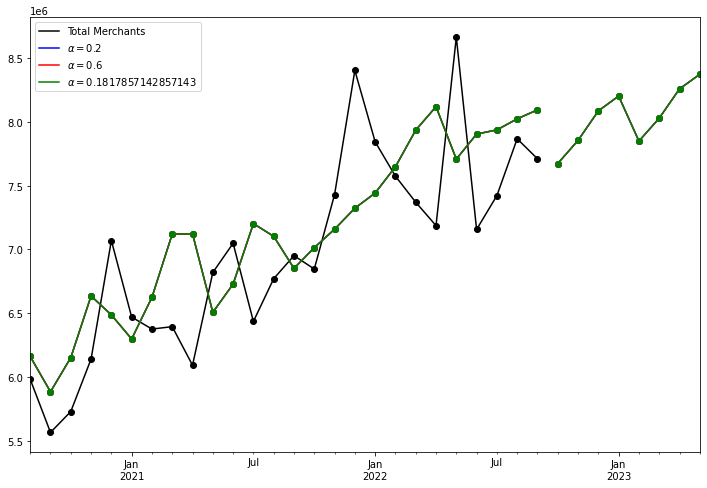

In [ ]:
ax = data.plot(marker='o', color='black', figsize=(12,8), label='Total Merchants')
ax.legend()
fcast1.plot(marker='o', ax=ax, color='blue', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
fcast2.plot(marker='o', ax=ax, color='red', legend=True)

fit2.fittedvalues.plot(marker='o', ax=ax, color='red')
fcast3.plot(marker='o', ax=ax, color='green', legend=True)
fit3.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()

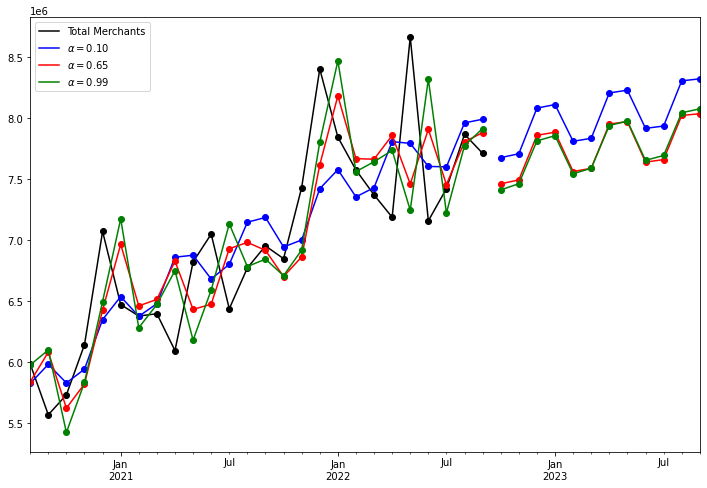

In [ ]:
ax = data.plot(marker='o', color='black', figsize=(12,8), label='Total Merchants')
ax.legend()
fcast4.plot(marker='o', ax=ax, color='blue', legend=True)
fit4.fittedvalues.plot(marker='o', ax=ax, color='blue')
fcast5.plot(marker='o', ax=ax, color='red', legend=True)
fit5.fittedvalues.plot(marker='o', ax=ax, color='red')
fcast6.plot(marker='o', ax=ax, color='green', legend=True)
fit6.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()

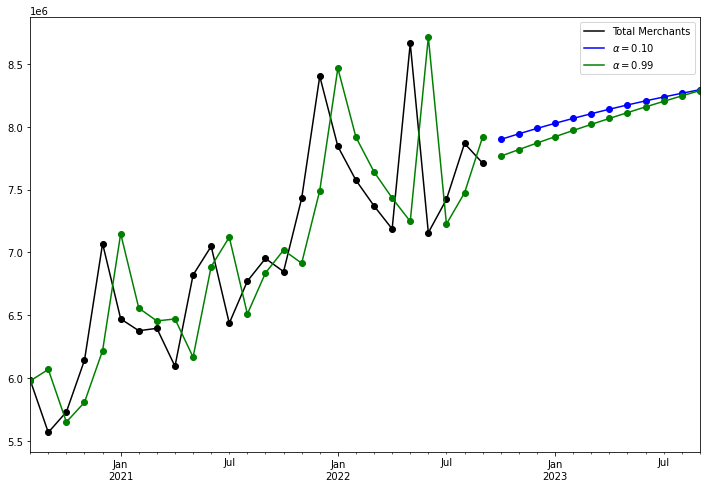

In [ ]:
ax = data.plot(marker='o', color='black', figsize=(12,8), label='Total Merchants')
ax.legend()
fcast7.plot(marker='o', ax=ax, color='blue', legend=True)
#fit7.fittedvalues.plot(marker='o', ax=ax, color='blue')
#fcast8.plot(marker='o', ax=ax, color='red', legend=True)
#fit8.fittedvalues.plot(marker='o', ax=ax, color='red')
fcast9.plot(marker='o', ax=ax, color='green', legend=True)
fit9.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()

In [ ]:
[fit6.params[p] for p in params] + [fit6.sse]

[1.4901249017671422e-08,
 3.558653714019118e-12,
 4.9774706448450225e-14,
 nan,
 72.10251367213553,
 0.15261668416378749,
 array([-2.00936532, -2.02012329, -2.46075073, -2.4645725 ]),
 True,
 0.1606145635425472,
 False,
 4720952802966.096]

In [ ]:
fit6.params

{'smoothing_level': 0.2,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 1.4937435548883642e-15,
 'damping_trend': nan,
 'initial_level': 71.98853269708408,
 'initial_trend': 0.14889662599499345,
 'initial_seasons': array([-2.02582546, -2.03265602, -2.50686071, -2.50704415]),
 'use_boxcox': True,
 'lamda': 0.1606145635425472,
 'remove_bias': False}

In [ ]:
pred = fit4.predict(0, 26)


NameError: ignored

In [ ]:
measure_rmse(test, predictions)

In [ ]:
def walk_forward_validation_1(data, n_test, cfg):
	predictions = list()
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error, n_test
walk_forward_validation_1(data, 18, ['mul',False,'add',6,False,False] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: Converg

(627749.9993636536, 18)

In [ ]:
# [t,d,s,p,b,r]
#model2 = ExponentialSmoothing(data, trend='mul', damped_trend=False, seasonal='add', seasonal_periods=6)
#fit4 = model2.fit(smoothing_level=0.2,)
#fcast4 = fit4.forecast(12).rename(r'$\alpha=0.2$')

# Model[['mul', False, 'add', 6, False, False]] 627749.999
# [trend, Damped, Seasonal, seasonal_periods, box-Cox Transform, Remove Bias]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  


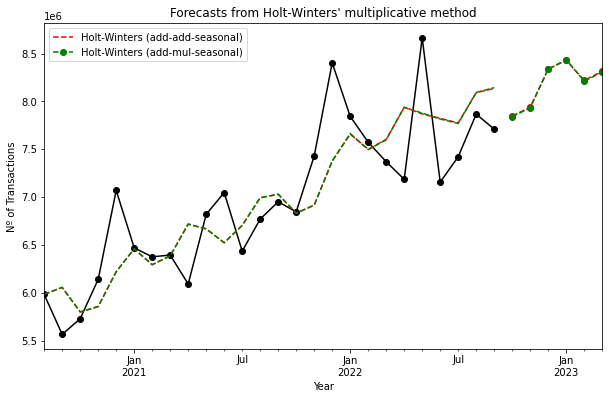

Figure 2: Forecasting Nº of Transactions using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Multiplicative,Additive Dam,Multiplica Dam
Alpha,0.2,0.2,0.2,0.2
Beta,0.0,0.0,0.0,0.0
phi,0.0,0.0,0.0,0.0
gamma,NaN,NaN,0.937052,0.937358
l_0,71.988533,70.13016,71.543138,70.138119
$b_0,0.148897,0.149636,0.345207,0.348257
initial seasons,"[-2.02582545971349, -2.0326560186616116, -2.50...","[0.9974743588729107, 0.9975330346111166, 0.990...","[-2.103437543769748, -2.1192841875354316, -2.6...","[0.9899235363944646, 0.989863489023993, 0.9825..."
Boxcox,True,True,True,True
lamda,0.160615,0.160615,0.160615,0.160615
Remove bias,False,False,False,False


In [ ]:
#TRIPLE EXPONENTIAL - Holt's Winters Seasonal

fit6 = ExponentialSmoothing(data, seasonal_periods=4, trend='add', seasonal='add').fit(smoothing_level=0.2, use_boxcox=True)
fit7 = ExponentialSmoothing(data, seasonal_periods=4, trend='add', seasonal='mul').fit(smoothing_level=0.2,use_boxcox=True)
fit8 = ExponentialSmoothing(data, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(smoothing_level=0.2, use_boxcox=True)
fit9 = ExponentialSmoothing(data, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(smoothing_level=0.2, use_boxcox=True)
results=pd.DataFrame(index=["Alpha","Beta","phi","gamma","l_0","$b_0","initial seasons", "Boxcox", 'lamda', 'Remove bias', 'Data'])
params = ['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'damping_trend', 'initial_level', 'initial_trend', 'initial_seasons','use_boxcox', 'lamda', 'remove_bias']
results["Additive"]       = [fit6.params[p] for p in params] + [fit6.sse]
results["Multiplicative"] = [fit7.params[p] for p in params] + [fit7.sse]
results["Additive Dam"]   = [fit8.params[p] for p in params] + [fit8.sse]
results["Multiplica Dam"] = [fit9.params[p] for p in params] + [fit9.sse]

ax = data.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Nº of Transactions")
ax.set_xlabel("Year")
fit6.fittedvalues.plot(ax=ax, style='--', color='red')
fit7.fittedvalues.plot(ax=ax, style='--', color='green')

fit6.forecast(6).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit7.forecast(6).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()
print("Figure 2: Forecasting Nº of Transactions using Holt-Winters method with both additive and multiplicative seasonality.")

results


In [ ]:
simulations = fit7.simulate(6, repetitions=100, error="mul")

ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Nº of Transactions")
ax.set_xlabel("Year")
fit7.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit7.forecast(6).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

NameError: ignored

In [ ]:
fit1.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,8789179216543.854
Optimized:,False,AIC,694.208
Trend:,None,BIC,696.724
Seasonal:,None,AICC,696.112
Seasonal Periods:,None,Date:,"Fri, 28 Oct 2022"
Box-Cox:,False,Time:,09:55:49
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
initial_level,5.9831e+06,l.0,False


In [ ]:
fit2.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,7560183294636.672
Optimized:,False,AIC,690.291
Trend:,None,BIC,692.808
Seasonal:,None,AICC,692.196
Seasonal Periods:,None,Date:,"Fri, 28 Oct 2022"
Box-Cox:,False,Time:,09:55:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6000000,alpha,False
initial_level,5.9831e+06,l.0,False


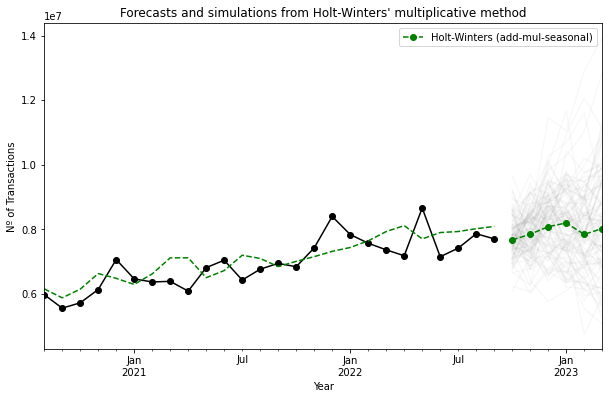

In [ ]:
simulations = fit2.simulate(6, repetitions=100, error="mul")

ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Nº of Transactions")
ax.set_xlabel("Year")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit2.forecast(6).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

In [ ]:
fit3.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,7290341611232.434
Optimized:,True,AIC,689.346
Trend:,None,BIC,691.863
Seasonal:,None,AICC,691.251
Seasonal Periods:,None,Date:,"Fri, 28 Oct 2022"
Box-Cox:,False,Time:,09:55:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4194186,alpha,True
initial_level,5.9831e+06,l.0,True


In [ ]:
fit4.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,5922962835728.853
Optimized:,True,AIC,699.946
Trend:,Multiplicative,BIC,712.527
Seasonal:,Additive,AICC,723.946
Seasonal Periods:,6,Date:,"Fri, 28 Oct 2022"
Box-Cox:,False,Time:,09:55:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_trend,0.0050000,beta,True


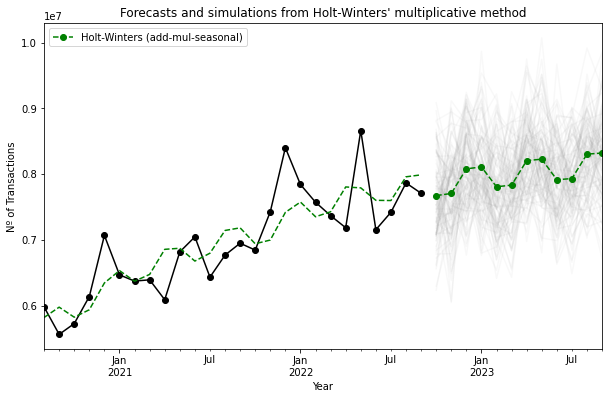

In [ ]:
simulations = fit4.simulate(12, repetitions=100, error="mul")

ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Nº of Transactions")
ax.set_xlabel("Year")
fit4.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit4.forecast(12).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

In [ ]:
fit5.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,7045954183546.131
Optimized:,True,AIC,704.460
Trend:,Multiplicative,BIC,717.041
Seasonal:,Additive,AICC,728.460
Seasonal Periods:,6,Date:,"Fri, 28 Oct 2022"
Box-Cox:,False,Time:,09:55:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6000000,alpha,False
smoothing_trend,0.0050000,beta,True


In [ ]:
fit6.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,4720952802966.096
Optimized:,True,AIC,690.048
Trend:,Additive,BIC,700.113
Seasonal:,Additive,AICC,704.715
Seasonal Periods:,4,Date:,"Fri, 28 Oct 2022"
Box-Cox:,True,Time:,09:56:00
Box-Cox Coeff.:,0.16061,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,3.5587e-12,beta,True


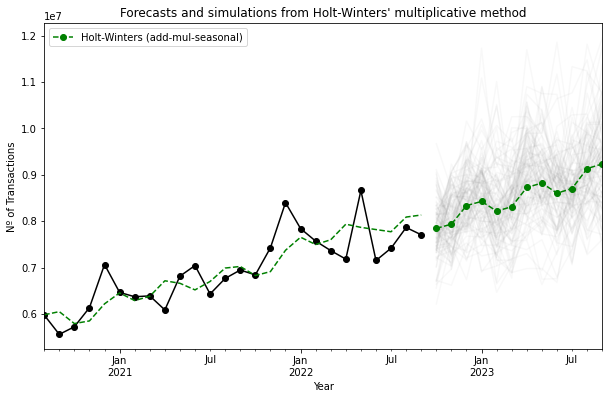

In [ ]:
simulations = fit6.simulate(12, repetitions=100, error="mul")

ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Nº of Transactions")
ax.set_xlabel("Year")
fit6.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit6.forecast(12).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

In [ ]:
fit7.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,4715177778537.878
Optimized:,True,AIC,690.016
Trend:,Additive,BIC,700.081
Seasonal:,Multiplicative,AICC,704.683
Seasonal Periods:,4,Date:,"Fri, 28 Oct 2022"
Box-Cox:,True,Time:,09:47:30
Box-Cox Coeff.:,0.16061,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,3.1357e-09,beta,True


In [ ]:
fit8.summary()

Dep. Variable:,SumMerchants,No. Observations:,26
Model:,ExponentialSmoothing,SSE,4203588394769.978
Optimized:,True,AIC,689.030
Trend:,Additive,BIC,700.353
Seasonal:,Additive,AICC,707.888
Seasonal Periods:,4,Date:,"Fri, 28 Oct 2022"
Box-Cox:,True,Time:,09:48:12
Box-Cox Coeff.:,0.16061,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,9.9667e-09,beta,True


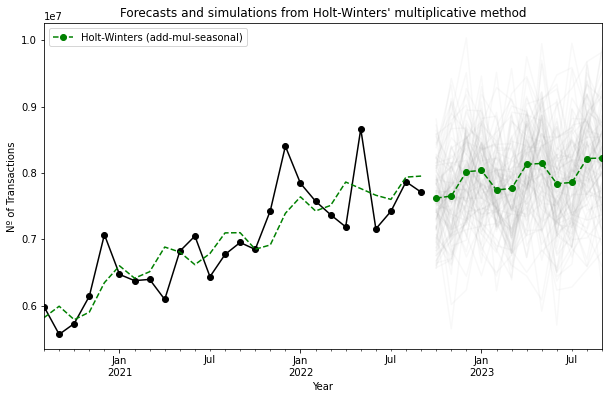

In [ ]:
simulations = fit8.simulate(12, repetitions=100, error="mul")

ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Nº of Transactions")
ax.set_xlabel("Year")
fit8.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit8.forecast(12).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()

In [ ]:
type(simulations)

pandas.core.frame.DataFrame